# Cloudy With a Chance of Football

## Wide Receivers Machine Learning Model

Author: Ermina Mujan

Date: 6/18/2021

    
- [Importing packages, setting preferences, reading in data](#import_set_read_cell)
- [Understanding the data](#data_review_cell)
- [Preparing the data](#preparing_data_cell)
- [Wide Receivers Machine Learning Model](#global_model_cell)
    - [Model Selection](#model_selection_cell)
        - [Selecting Columns](#column_selection_cell)
        - [Selecting models to score](#model_scoring_selection_cell)
        - [Scoring and visualizing selected models](#scoring_models_cell)
    - [Grid Search](#grid_search_cell)
        - [Grid Searching the Support Vector Classifier](#svc_gridsearch_cell)
        - [Grid Searching the Stochastic Gradient Descent Classifier](#sdg_gridsearch_cell)
    - [Visualizing SDGClassifier Model Performance with a Confusion Matrix](#confusion_matrix_cell)
    - [Time Series Split Cross Validation](#time_series_split_cv)
    - [Pickling the Model for Future Use](#pickling_cell)




### Importing packages, setting preferences, reading in data
<a id='import_set_read_cell'></a>

In [1]:
# Packages to import and manipulate data
import pandas as pd
import numpy as np
import sqlite3

# Packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Packages to create and visualize machine learning models from yellowbrick
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import confusion_matrix

# Packages to create machine learning models from scikit-learn
from sklearn.model_selection import train_test_split as tts
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

In [2]:
# Set pandas viewing options
pd.set_option('display.max_columns', None)

# Bring in jupyter magic
%matplotlib inline

# Set matplotlib visualization styling options
plt.rcParams['figure.figsize'] = (18,6)
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv( '../../fixtures/cleaned_data/merged_df.csv')

In [4]:
# Read in all data from database and merge the data on player_id
conn = sqlite3.connect('../../fixtures/database/cloudy_with_a_chance_of_football.db')
cursorObj = conn.cursor()

target = pd.read_sql_query('SELECT * from performance_target',conn)

In [5]:
df = pd.merge(
    df,
    target,
    how = 'left',
    left_on = ['PlayerID','week_id','performance'],
    right_on = ['PlayerID','week_id','performance']
)

df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,performance,projected,actual,difference,performance_class
0,201910101,1,2019,1,ARZ,DET,HOME,DEF,DEF,0,1,11,16994,2019_1,0,365,0,72,0,No wind,0.39,0.0,0.32,DOME,0,25.354502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.90,7.0,1.10,far overperformed
1,201910203,1,2019,2,ARZ,BLT,AWAY,DEF,DEF,0,1,3,17008,2019_2,0,7,2,81,3,North - NorthWest,0.00,0.0,0.45,Clear,3226593,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,24.0,11.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,27.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.40,2.0,-3.40,far underperformed
2,201910301,1,2019,3,ARZ,CAR,HOME,DEF,DEF,0,1,5,17024,2019_3,0,7,0,72,0,No wind,0.40,0.0,0.90,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,2.0,14.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,23.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.00,0.0,-8.00,far underperformed
3,201910401,1,2019,4,ARZ,SEA,HOME,DEF,DEF,0,1,30,17041,2019_4,0,7,0,72,0,No wind,0.38,0.0,0.36,DOME,0,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,21.0,4.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,38.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.70,4.0,-1.70,far underperformed
4,201910507,1,2019,5,ARZ,CIN,AWAY,DEF,DEF,0,1,7,17047,2019_5,0,7,2,76,6,West - SouthWest,0.87,0.0,0.60,Mostly Cloudy,1792624,25.354502,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,4.0,15.0,7.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Understanding the data
<a id='data_review_cell'></a>

In [6]:
list(df)

['GameKey',
 'PlayerID',
 'Season',
 'Week',
 'Team',
 'Opponent',
 'HomeOrAway',
 'Position',
 'PositionCategory',
 'InjuryStatus',
 'TeamID',
 'OpponentID',
 'ScoreID',
 'week_id',
 'OpponentRZ',
 'days_since_last_game',
 'absolute_hours_displaced',
 'weather_temperature',
 'weather_wind_mph_number',
 'weather_wind_direction',
 'weather_cloud_cover',
 'weather_precipitation',
 'weather_humidity',
 'weather_detail',
 'elevation_displacement',
 'age',
 'Played',
 'Started',
 'PassingAttempts',
 'PassingCompletions',
 'PassingYards',
 'PassingCompletionPercentage',
 'PassingYardsPerAttempt',
 'PassingYardsPerCompletion',
 'PassingTouchdowns',
 'PassingInterceptions',
 'PassingRating',
 'PassingLong',
 'PassingSacks',
 'PassingSackYards',
 'RushingAttempts',
 'RushingYards',
 'RushingYardsPerAttempt',
 'RushingTouchdowns',
 'RushingLong',
 'ReceivingTargets',
 'Receptions',
 'ReceivingYards',
 'ReceivingYardsPerReception',
 'ReceivingTouchdowns',
 'ReceivingLong',
 'Fumbles',
 'FumblesLo

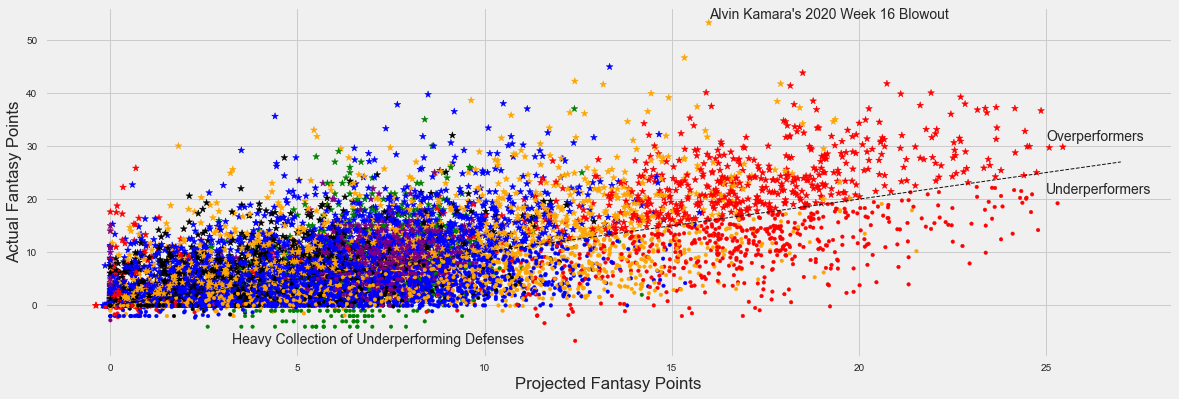

In [7]:
labels = list(df['Position'])
colors = {
    'DEF':'green',
    'WR':'blue',
    'QB':'red',
    'K':'purple',
    'TE':'black',
    'RB':'orange'
}
plt.scatter(
    df['projected'][df['performance'] == 1.0],
    df['actual'][df['performance'] == 1.0],
    c = df['Position'][df['performance'] == 1.0].map(colors),
    marker = '*'
)
plt.scatter(
    df['projected'][df['performance'] == 0.0],
    df['actual'][df['performance'] == 0.0],
    c = df['Position'][df['performance'] == 0.0].map(colors),
    marker = '.'
)
plt.plot(
    [
        0,
        27
    ],[
        0,
        27
    ],
    'k',
    lw = 1,
    linestyle = 'dashed'
)
plt.ylabel(
    'Actual Fantasy Points',
    fontsize  = 'large'
)
plt.xlabel(
    'Projected Fantasy Points',
    fontsize  = 'large'
)
plt.text(
    16,
    54,
    "Alvin Kamara's 2020 Week 16 Blowout"
)
plt.text(
    25,
    31,
    "Overperformers"
)
plt.text(
    25,
    21,
    "Underperformers"
)    
plt.text(
    3.25,
    -7.25,
    "Heavy Collection of Underperforming Defenses"
)

plt.show()

<AxesSubplot:xlabel='Position'>

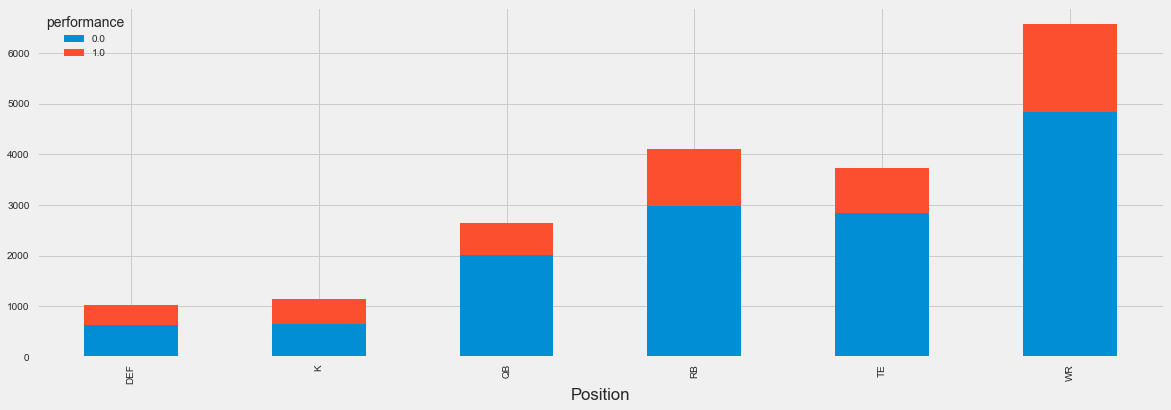

In [8]:
#performace by position

agg_df = df.groupby(['Position','performance'])['Position'].count().unstack().fillna(0)

agg_df.plot(kind = 'bar', stacked = True)

<AxesSubplot:xlabel='Position'>

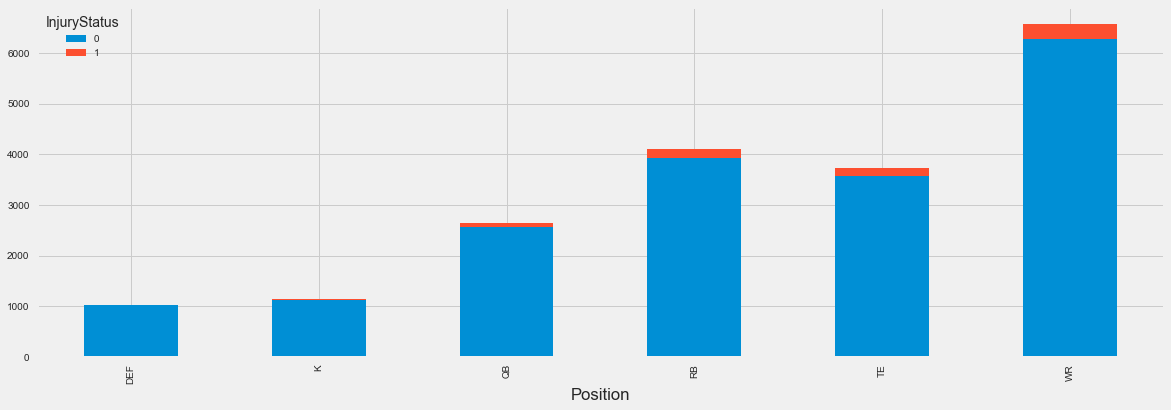

In [9]:
#injury status by position

agg_df = df.groupby(['Position','InjuryStatus'])['Position'].count().unstack().fillna(0)

agg_df.plot(kind = 'bar', stacked = True)

In [10]:
agg_df = df.groupby(['Position','InjuryStatus'])['Position'].count().unstack().fillna(0)
agg_df

InjuryStatus,0,1
Position,,
DEF,1024.0,0.0
K,1125.0,12.0
QB,2573.0,69.0
RB,3920.0,181.0
TE,3569.0,161.0
WR,6269.0,312.0


In [11]:
df.describe()

,GameKey,PlayerID,Season,Week,InjuryStatus,TeamID,OpponentID,ScoreID,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_cloud_cover,weather_precipitation,weather_humidity,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,performance,projected,actual,difference
count,1.921500e+04,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,1.921500e+04,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.00000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.00000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.0,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.000000,19215.0,19215.0,19215.000000,19215.0,19215.000000,19215.000000,19215.000000,19215.000000
mean,2.019616e+08,16929.806037,2019.507104,9.100286,0.038251,17.972678,17.756596,17258.040853,26.297788,0.506427,62.605829,4.889722,0.393791,0.018771,0.621109,1.050382e+06,26.508028,0.718501,0.329482,1.736872,1.122248,12.597138,3.759308,0.43744,0.654749,0.081395,0.038251,5.361079,2.044965,0.116732,0.783607,1.309394,5.700494,0.852615,0.047047,2.190060,1.657715,1.114390,12.527921,3.928186,0.079625,6.20791,0.054749,0.026282,0.072339,0.600052,0.001353,0.079365,1.771429,0.001093,0.063908,0.014572,0.268800,0.118345,0.793130,0.290242,0.000104,0.042831,0.029560,0.002810,0.039032,0.003175,0.093156,0.077804,0.114598,0.003955,0.001821,0.003903,0.122560,0.000677,0.020973,0.023679,0.023159,0.009316,1.146552,0.000468,1.185480,0.001874,0.005829,0.002810,0.000052,0.0,0.001926,0.007702,0.894249,0.056466,0.004215,0.651835,0.041634,0.129742,0.888108,0.055009,0.0,0.0,0.000104,0.0,0.274161,4.261863,4.280412,0.018550
std,5.000395e+04,5575.428964,0.499963,5.018690,0.191807,10.432115,10.463184,165.690724,74.542025,0.906557,15.328872,4.437656,0.3

In [12]:
df['age'].mean()

26.508027554307855

In [13]:
df['PlayerID'].nunique()

912

In [14]:
boxplot_cols = [
 'days_since_last_game',
 'absolute_hours_displaced',
 'weather_temperature',
 'weather_wind_mph_number',
 'weather_cloud_cover',
 'weather_precipitation',
 'weather_humidity',
 'age',
 'elevation_displacement',
 'performance',
 'difference'
]

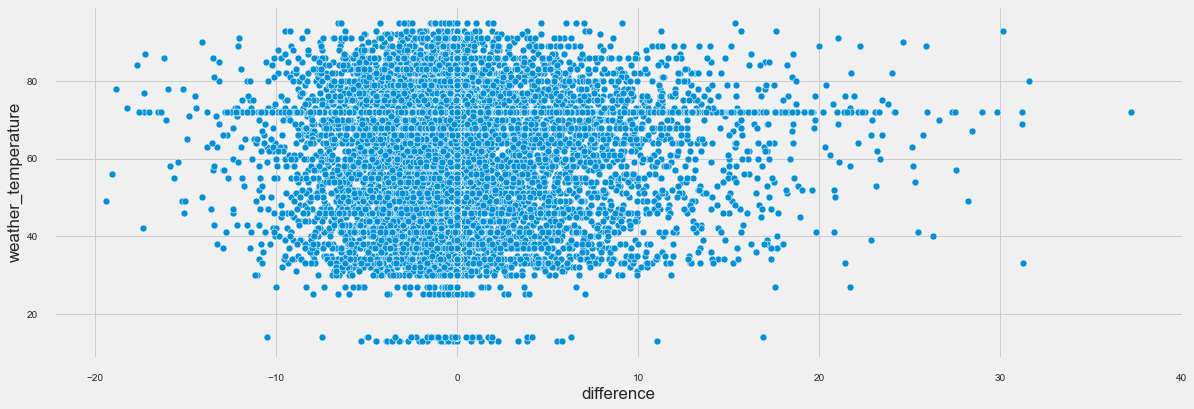

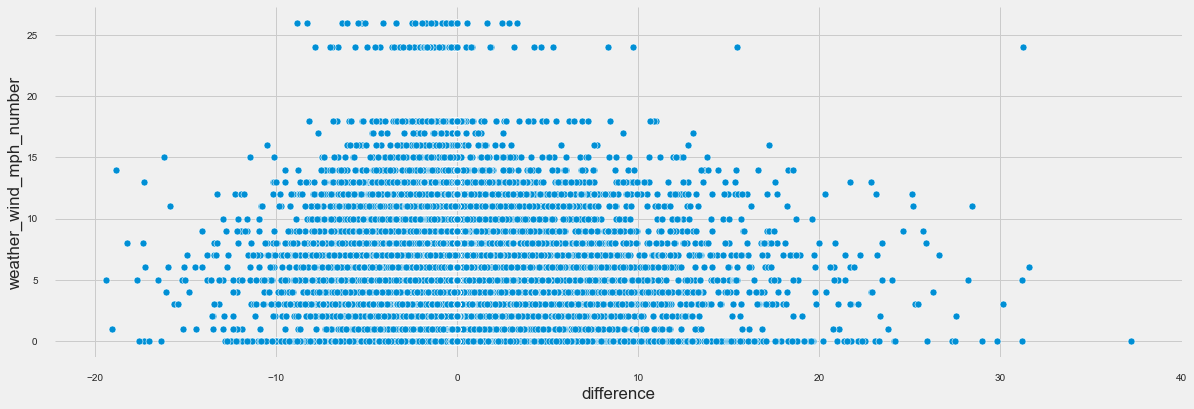

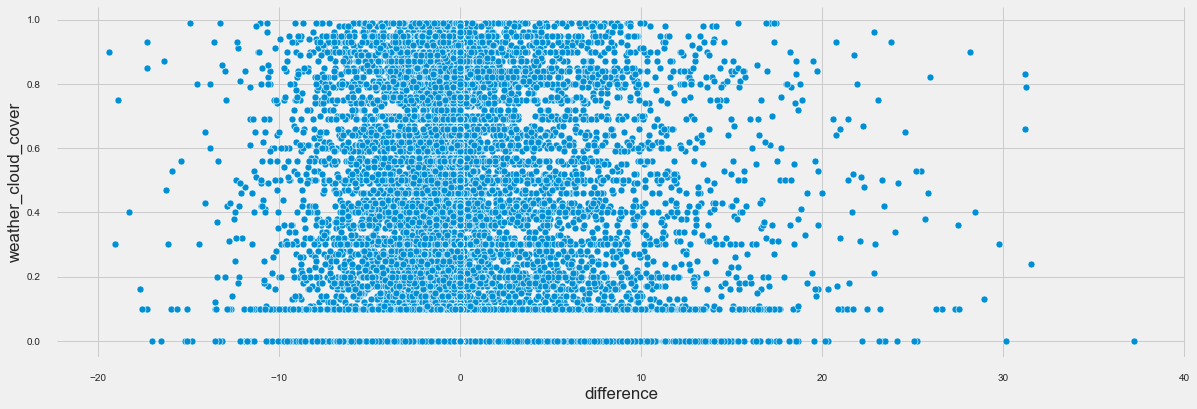

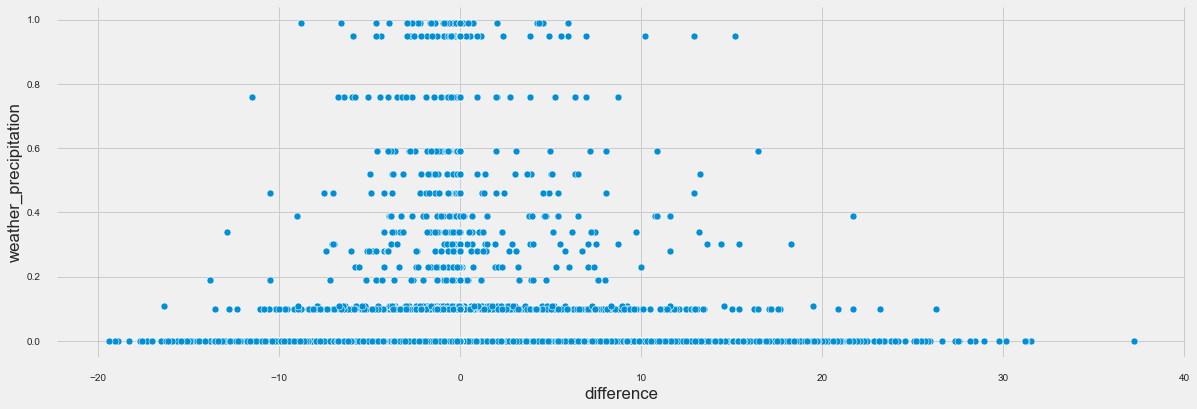

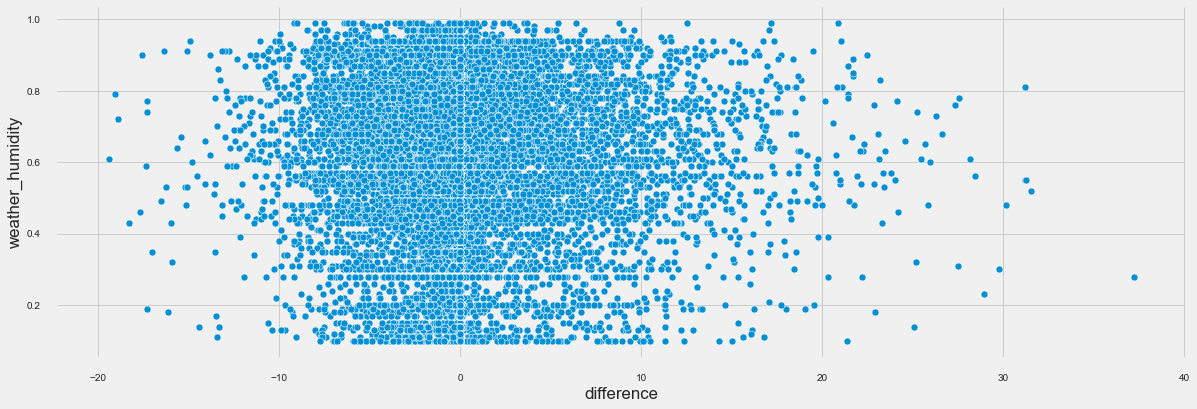

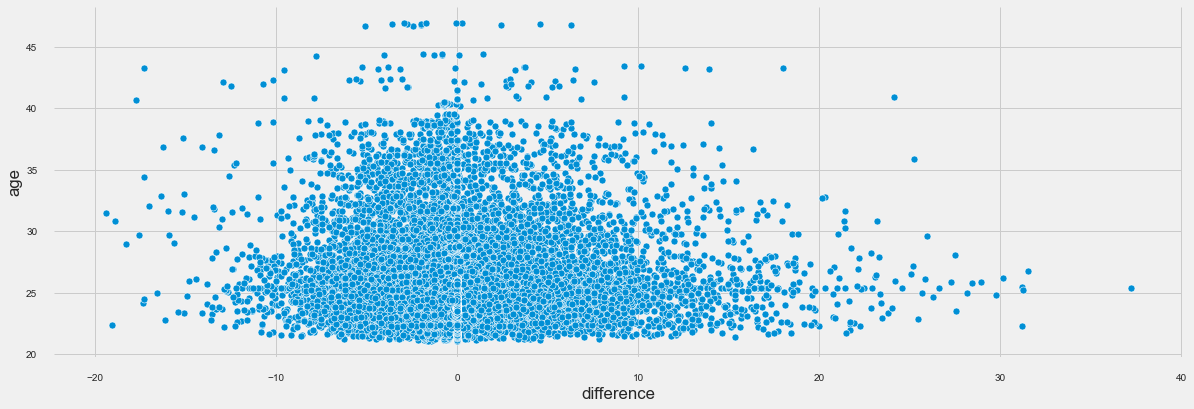

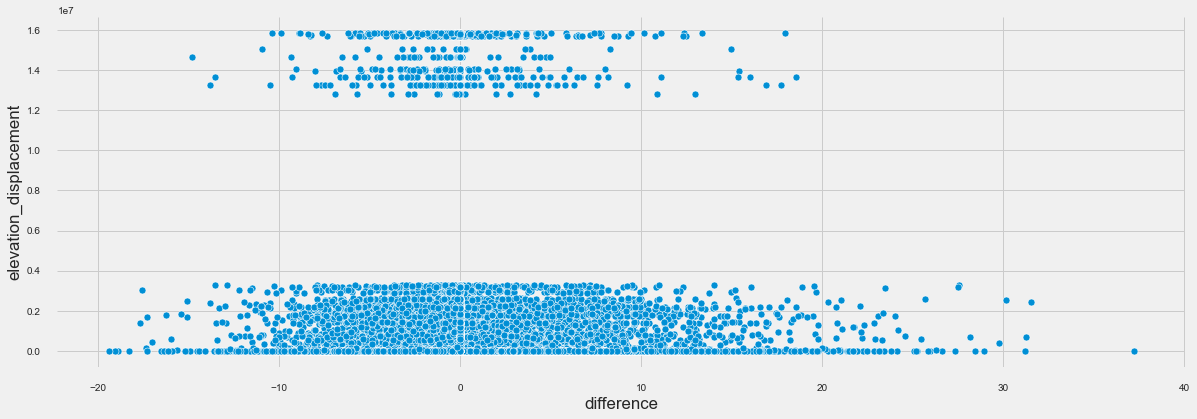

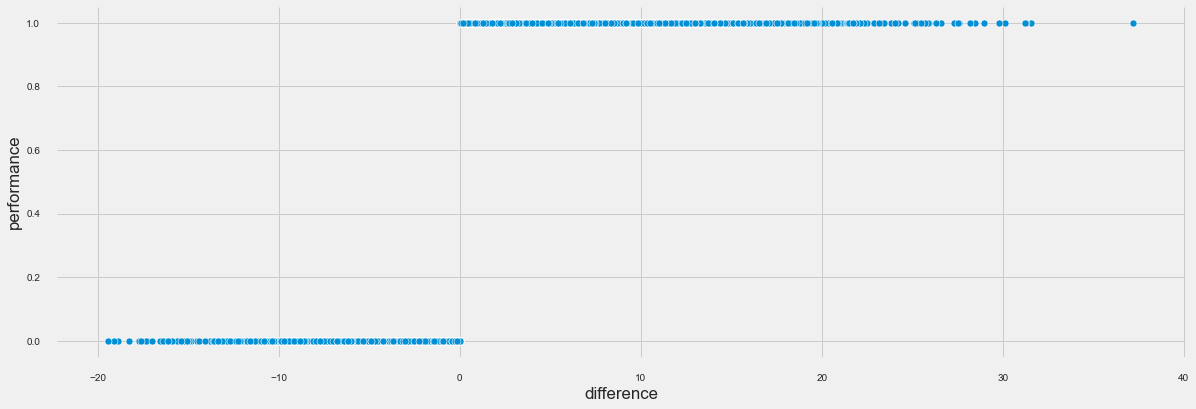

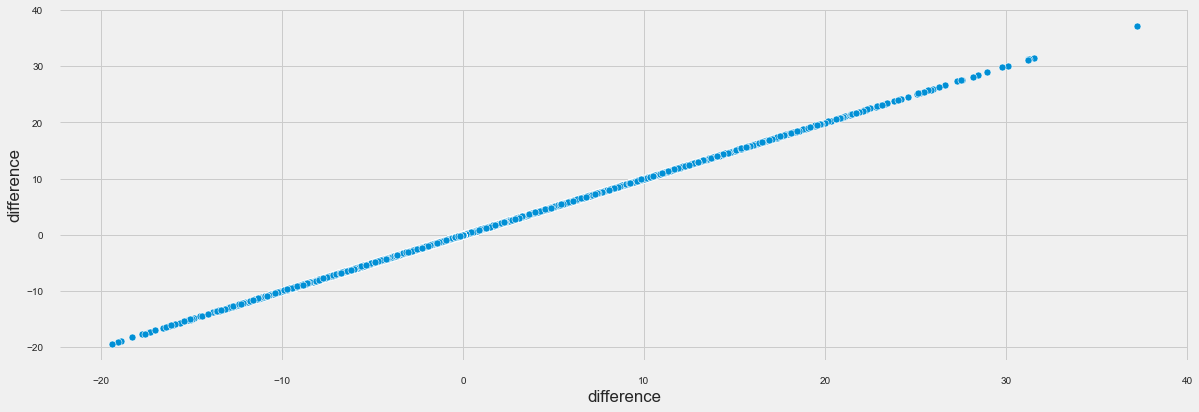

In [15]:
for col in df[boxplot_cols].columns[2:len(df[boxplot_cols].columns)]:
    
    sns.scatterplot(x = 'difference', y = col, palette=['b','r'], data=df)
    sns.despine(offset=10, trim=True)

    plt.show()
    plt.clf()

plt.close()

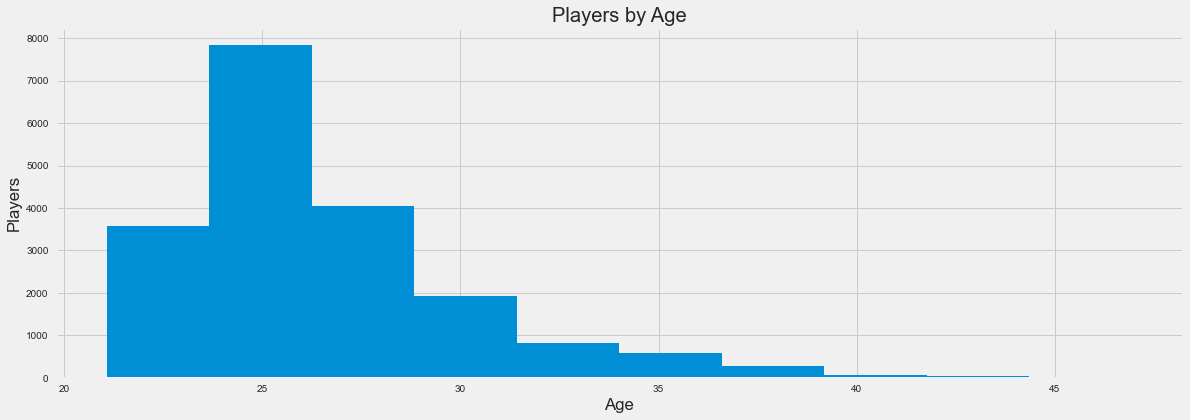

In [16]:
# Create a histogram to examine distribution of players by age

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(df['age'], bins = 10, range = (df['age'].min(),df['age'].max()))
plt.title("Players by Age")
plt.xlabel('Age')
plt.ylabel('Players')
plt.show()

array([[<AxesSubplot:xlabel='projected', ylabel='projected'>,
        <AxesSubplot:xlabel='actual', ylabel='projected'>],
       [<AxesSubplot:xlabel='projected', ylabel='actual'>,
        <AxesSubplot:xlabel='actual', ylabel='actual'>]], dtype=object)

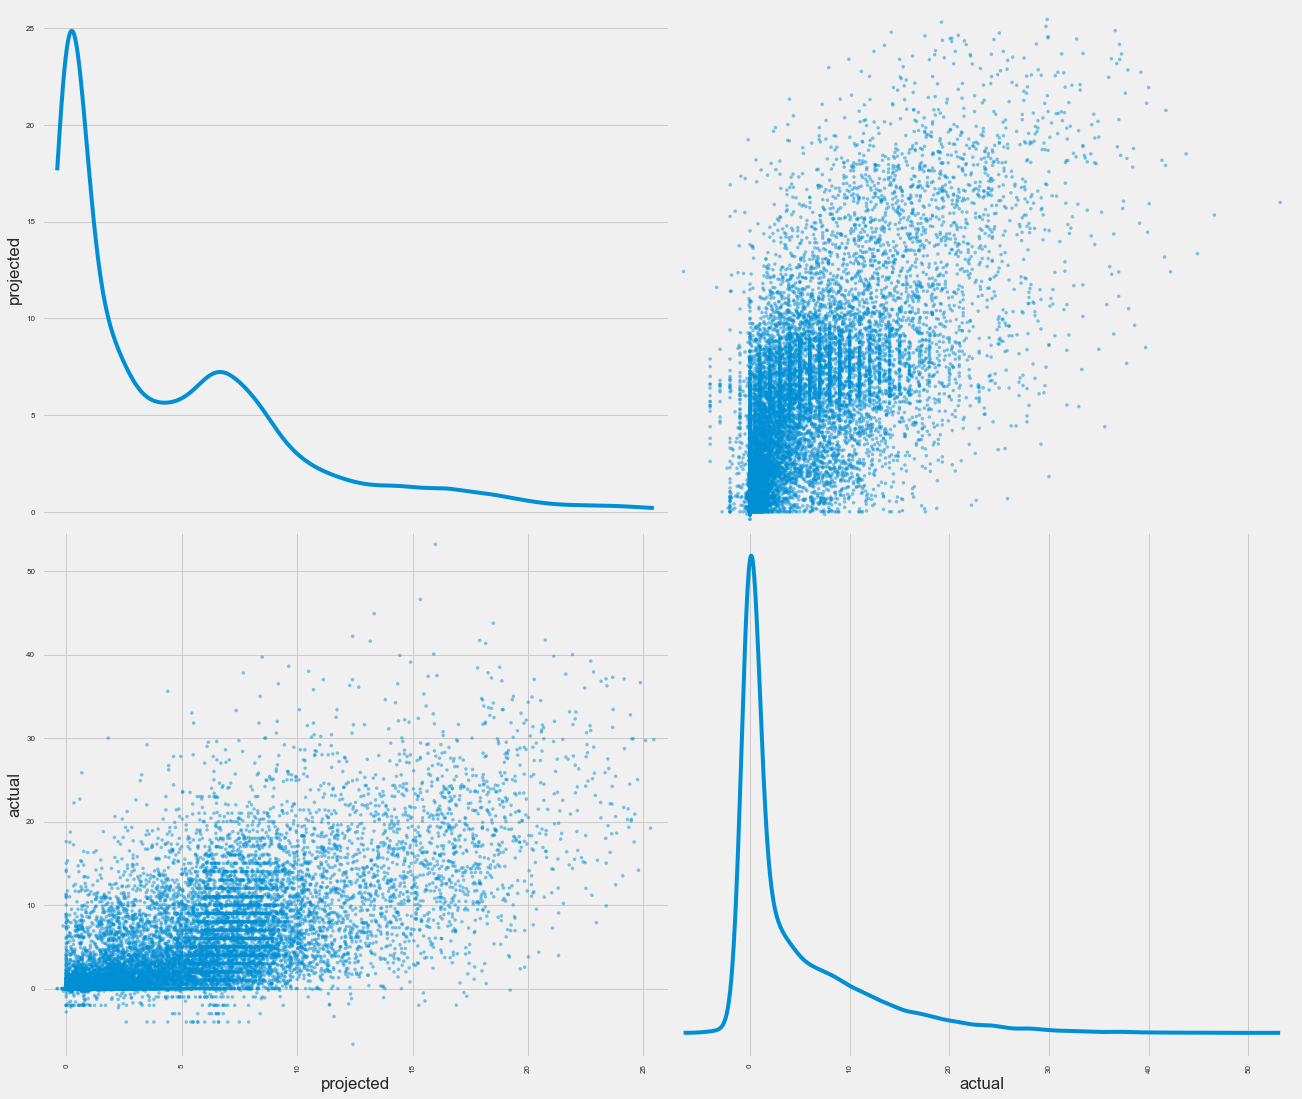

In [17]:
areas = df[['projected','actual',]]
pd.plotting.scatter_matrix(areas, alpha=0.5, figsize=(20,18), diagonal='kde')





<AxesSubplot:xlabel='Position', ylabel='age'>

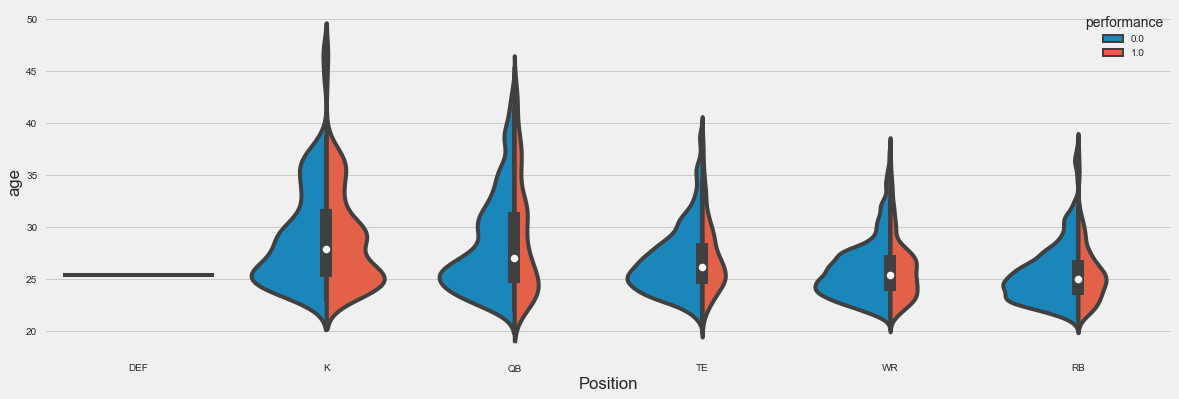

In [18]:
sns.violinplot(x=df['Position'], y=df['age'], hue=df['performance'],  df=df, split=True, scale='count')

<AxesSubplot:xlabel='Position', ylabel='weather_temperature'>

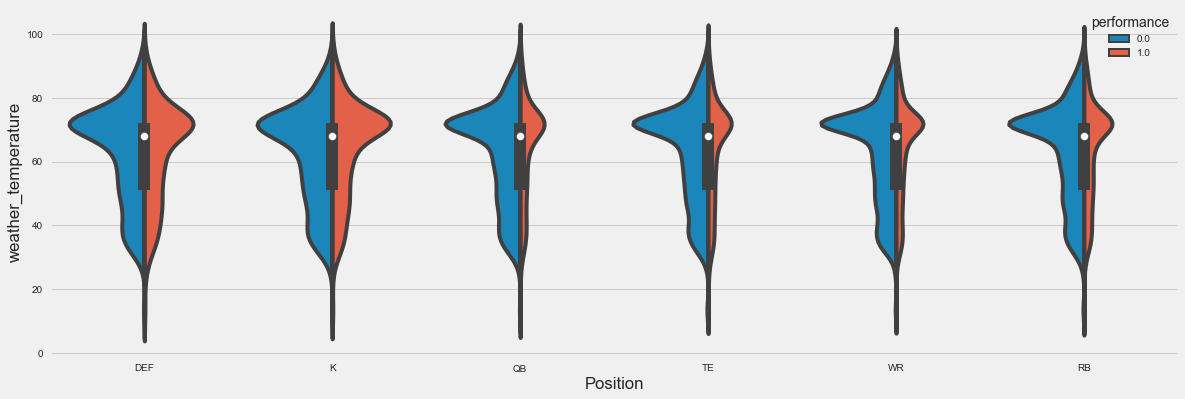

In [19]:
sns.violinplot(x=df['Position'], y=df['weather_temperature'], hue=df['performance'],  df=df, split=True, scale='count')

In [20]:
players_per_pos = df.groupby('Position').size()
players_per_pos

Position
DEF    1024
K      1137
QB     2642
RB     4101
TE     3730
WR     6581
dtype: int64

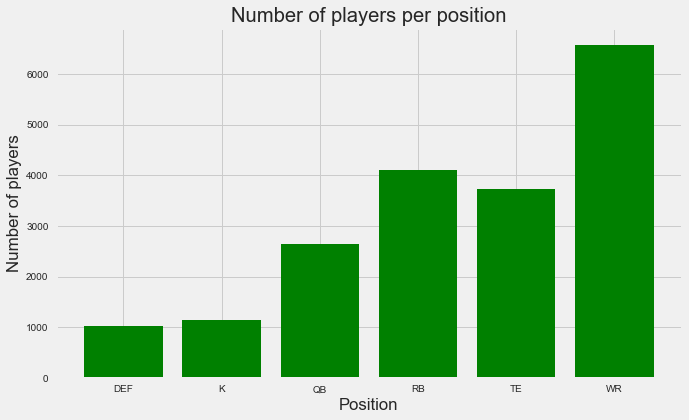

In [21]:
plt.figure(figsize=(10,6))
plt.bar(players_per_pos.index,players_per_pos.values, color="green")
plt.title('Number of players per position')
plt.xlabel('Position')
plt.ylabel('Number of players')

plt.show()

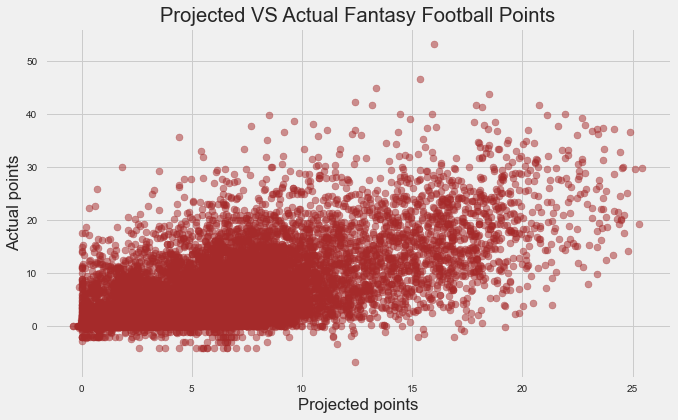

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(df['projected'], df['actual'], alpha = 0.5, color="brown")

plt.xlabel('Projected points')
plt.ylabel('Actual points')
plt.title('Projected VS Actual Fantasy Football Points')
plt.show()

In [23]:
# Find out basic characteristics of the columns and, if necessary, drop columns with null values
df.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19215 entries, 0 to 19214
Data columns (total 110 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   GameKey                             19215 non-null  int64  
 1   PlayerID                            19215 non-null  int64  
 2   Season                              19215 non-null  int64  
 3   Week                                19215 non-null  int64  
 4   Team                                19215 non-null  object 
 5   Opponent                            19215 non-null  object 
 6   HomeOrAway                          19215 non-null  object 
 7   Position                            19215 non-null  object 
 8   PositionCategory                    19215 non-null  object 
 9   InjuryStatus                        19215 non-null  int64  
 10  TeamID                              19215 non-null  int64  
 11  OpponentID                          1921

### Preparing the data
<a id='preparing_data_cell'></a>

In [24]:
df['Position'].unique()

array(['DEF', 'K', 'QB', 'TE', 'WR', 'RB'], dtype=object)

In [25]:
df = df[df['Position'] == 'WR']

In [26]:
df

,GameKey,PlayerID,Season,Week,Team,Opponent,HomeOrAway,Position,PositionCategory,InjuryStatus,TeamID,OpponentID,ScoreID,week_id,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,SoloTackles,AssistedTackles,TacklesForLoss,Sacks,SackYards,QuarterbackHits,PassesDefended,FumblesForced,FumblesRecovered,FumbleReturnTouchdowns,Interceptions,InterceptionReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,ExtraPointsAttempted,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,PointsAllowedByDefenseSpecialTeams,BlockedKickReturnTouchdowns,PointsAllowed,SpecialTeamsTouchdowns,DefensiveTouchdowns,BlockedKicks,TwoPointConversionReturns,FieldGoalReturnTouchdowns,Safeties,TouchdownsScored,PassingYardsRZ,PassingTouchdownsRZ,PassingInterceptionsRZ,RushingYardsRZ,RushingTouchdownsRZ,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,SacksRZ,InterceptionsRZ,FumblesForcedRZ,FumlbesRecoveredRZ,performance,projected,actual,difference,performance_class
682,201910126,3943,2019,1,PHI,WAS,HOME,WR,OFF,0,26,35,16988,2019_1,WAS,365,0,79,4,West,0.16,0.0,0.39,Partly Cloudy,0,32.771492,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.06,27.4,20.34,far overperformed
683,201910202,3943,2019,2,PHI,ATL,AWAY,WR,OFF,1,26,2,17013,2019_2,0,7,0,72,0,No wind,0.31,0.0,0.56,DOME,3004588,32.791494,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,8.0,154.0,19.2,2.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.04,0.0,-9.04,far underperformed
684,201910326,3943,2019,3,PHI,DET,HOME,WR,OFF,0,26,11,17023,2019_3,0,7,0,86,5,South - SouthWest,0.00,0.0,0.47,Clear,0,32.809823,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,overperformed
685,201910412,3943,2019,4,PHI,GB,AWAY,WR,OFF,1,26,12,17031,2019_4,0,4,1,60,2,South,0.00,0.0,0.57,Clear,1873696,32.821611,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,overperformed
686,201910526,3943,2019,5,PHI,NYJ,HOME,WR,OFF,1,26,24,17052,2019_5,0,10,0,70,7,South,0.10,0.0,0.68,Overcast,0,32.848153,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [27]:
list(df)

['GameKey',
 'PlayerID',
 'Season',
 'Week',
 'Team',
 'Opponent',
 'HomeOrAway',
 'Position',
 'PositionCategory',
 'InjuryStatus',
 'TeamID',
 'OpponentID',
 'ScoreID',
 'week_id',
 'OpponentRZ',
 'days_since_last_game',
 'absolute_hours_displaced',
 'weather_temperature',
 'weather_wind_mph_number',
 'weather_wind_direction',
 'weather_cloud_cover',
 'weather_precipitation',
 'weather_humidity',
 'weather_detail',
 'elevation_displacement',
 'age',
 'Played',
 'Started',
 'PassingAttempts',
 'PassingCompletions',
 'PassingYards',
 'PassingCompletionPercentage',
 'PassingYardsPerAttempt',
 'PassingYardsPerCompletion',
 'PassingTouchdowns',
 'PassingInterceptions',
 'PassingRating',
 'PassingLong',
 'PassingSacks',
 'PassingSackYards',
 'RushingAttempts',
 'RushingYards',
 'RushingYardsPerAttempt',
 'RushingTouchdowns',
 'RushingLong',
 'ReceivingTargets',
 'Receptions',
 'ReceivingYards',
 'ReceivingYardsPerReception',
 'ReceivingTouchdowns',
 'ReceivingLong',
 'Fumbles',
 'FumblesLo

In [28]:
df = df.drop(columns=['PositionCategory',                   
 'GameKey',
 'TeamID',
 'OpponentID',
 'ScoreID',
 'PlayerID',
 'week_id',
 'PassingAttempts',
 'PassingCompletions',
 'PassingYards',
 'PassingCompletionPercentage',
 'PassingYardsPerAttempt',
 'PassingYardsPerCompletion',
 'PassingTouchdowns',
 'PassingInterceptions',
 'PassingRating',
 'PassingLong',
 'PassingSacks',
 'PassingSackYards',
 'RushingAttempts',
 'RushingYards',
 'RushingYardsPerAttempt',
 'RushingTouchdowns',
 'RushingLong',
 'PuntReturns',
 'PuntReturnYards',
 'PuntReturnTouchdowns',
 'KickReturns',
 'KickReturnYards',
 'KickReturnTouchdowns',
 'SoloTackles',
 'AssistedTackles',
 'TacklesForLoss',
 'Sacks',
 'SackYards',
 'QuarterbackHits',
 'PassesDefended',
 'FumblesForced',
 'FumblesRecovered',
 'FumbleReturnTouchdowns',
 'Interceptions',
 'InterceptionReturnTouchdowns',
 'FieldGoalsAttempted',
 'FieldGoalsMade',
 'ExtraPointsMade',
 'TwoPointConversionPasses',
 'TwoPointConversionRuns',
 'ExtraPointsAttempted',
 'FieldGoalsMade0to19',
 'FieldGoalsMade20to29',
 'FieldGoalsMade30to39',
 'FieldGoalsMade40to49',
 'FieldGoalsMade50Plus',
 'PointsAllowedByDefenseSpecialTeams',
 'BlockedKickReturnTouchdowns',
 'PointsAllowed',
 'SpecialTeamsTouchdowns',
 'DefensiveTouchdowns',
 'BlockedKicks',
 'TwoPointConversionReturns',
 'FieldGoalReturnTouchdowns',
 'Safeties',
 'PassingYardsRZ',
 'PassingTouchdownsRZ',
 'PassingInterceptionsRZ',
 'RushingYardsRZ',
 'RushingTouchdownsRZ',
 'SacksRZ',
 'InterceptionsRZ',
 'FumblesForcedRZ',
 'FumlbesRecoveredRZ',
 'performance_class',
 'projected',
 'actual',
 'difference',
])


In [29]:
df

,Season,Week,Team,Opponent,HomeOrAway,Position,InjuryStatus,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,TwoPointConversionReceptions,TouchdownsScored,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,performance
682,2019,1,PHI,WAS,HOME,WR,0,WAS,365,0,79,4,West,0.16,0.0,0.39,Partly Cloudy,0,32.771492,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
683,2019,2,PHI,ATL,AWAY,WR,1,0,7,0,72,0,No wind,0.31,0.0,0.56,DOME,3004588,32.791494,1,1,9.0,8.0,154.0,19.2,2.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684,2019,3,PHI,DET,HOME,WR,0,0,7,0,86,5,South - SouthWest,0.00,0.0,0.47,Clear,0,32.809823,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
685,2019,4,PHI,GB,AWAY,WR,1,0,4,1,60,2,South,0.00,0.0,0.57,Clear,1873696,32.821611,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
686,2019,5,PHI,NYJ,HOME,WR,1,0,10,0,70,7,South,0.10,0.0,0.68,Overcast,0,32.848153,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19171,2020,13,NE,LAC,AWAY,WR,0,0,7,3,70,4,West - SouthWest,0.30,0.0,0.18,Clear,617204,23.906539,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19172,2020,14,NE,LAR,AWAY,WR,0,0,4,3,60,4,South,0.25,0.0,0.66,Clear,638582,23.917937,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19173,2020,15,NE,MIA,AWAY,WR,0,0,10,0,79,9,South,0.41,0.0,0.69,Partly Cloudy,753825,23.944480,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19174,2020,16,NE,BUF,HOME,WR,0,0,8,0,41,5,SouthWest,0.17,0.0,0.81,Clear,0,23.967210,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df = df.drop('Season', axis = 'columns').sort_values(by = ['Week']).reset_index(drop = True)
df

,Week,Team,Opponent,HomeOrAway,Position,InjuryStatus,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,TwoPointConversionReceptions,TouchdownsScored,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ,performance
0,1,PHI,WAS,HOME,WR,0,WAS,365,0,79,4,West,0.16,0.0,0.39,Partly Cloudy,0,32.771492,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,TEN,DEN,AWAY,WR,0,0,260,1,78,7,NorthEast,0.40,0.0,0.17,Foggy,14625059,26.105753,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,LAR,CAR,AWAY,WR,0,CAR,365,3,85,3,East,0.00,0.0,0.48,Clear,790202,25.064284,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,PHI,WAS,HOME,WR,0,0,365,0,79,4,West,0.16,0.0,0.39,Partly Cloudy,0,30.529146,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,DET,CHI,HOME,WR,0,0,259,0,72,0,No wind,0.12,0.0,0.65,DOME,0,26.655008,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6576,17,CIN,BLT,HOME,WR,0,0,7,0,38,8,West,0.99,0.0,0.83,Overcast,0,24.325049,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6577,17,MIA,NE,AWAY,WR,0,0,7,0,40,2,North,0.64,0.0,0.51,Mostly Cloudy,753825,28.130740,1,1,2.0,2.0,41.0,20.5,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6578,17,BLT,CIN,AWAY,WR,0,0,7,0,38,8,West,0.99,0.0,0.83,Overcast,1433969,32.166415,1,0,1.0,1.0,8.0,8.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,8.0,1.0,0.0
6579,17,PIT,CLV,AWAY,WR,0,0,7,0,38,5,West,0.10,0.0,0.88,Overcast,431862,24.500275,1,1,14.0,8.0,74.0,9.2,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Wide Receivers Machine Learning Model
<a id='wr_model_cell'></a>

In [31]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop(['performance'], axis = 'columns')

y = df['performance']

In [32]:
X

,Week,Team,Opponent,HomeOrAway,Position,InjuryStatus,OpponentRZ,days_since_last_game,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,elevation_displacement,age,Played,Started,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,TwoPointConversionReceptions,TouchdownsScored,ReceptionsRZ,ReceivingYardsRZ,ReceivingTouchdownsRZ
0,1,PHI,WAS,HOME,WR,0,WAS,365,0,79,4,West,0.16,0.0,0.39,Partly Cloudy,0,32.771492,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,TEN,DEN,AWAY,WR,0,0,260,1,78,7,NorthEast,0.40,0.0,0.17,Foggy,14625059,26.105753,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,LAR,CAR,AWAY,WR,0,CAR,365,3,85,3,East,0.00,0.0,0.48,Clear,790202,25.064284,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,PHI,WAS,HOME,WR,0,0,365,0,79,4,West,0.16,0.0,0.39,Partly Cloudy,0,30.529146,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,DET,CHI,HOME,WR,0,0,259,0,72,0,No wind,0.12,0.0,0.65,DOME,0,26.655008,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6576,17,CIN,BLT,HOME,WR,0,0,7,0,38,8,West,0.99,0.0,0.83,Overcast,0,24.325049,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6577,17,MIA,NE,AWAY,WR,0,0,7,0,40,2,North,0.64,0.0,0.51,Mostly Cloudy,753825,28.130740,1,1,2.0,2.0,41.0,20.5,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6578,17,BLT,CIN,AWAY,WR,0,0,7,0,38,8,West,0.99,0.0,0.83,Overcast,1433969,32.166415,1,0,1.0,1.0,8.0,8.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,8.0,1.0
6579,17,PIT,CLV,AWAY,WR,0,0,7,0,38,5,West,0.10,0.0,0.88,Overcast,431862,24.500275,1,1,14.0,8.0,74.0,9.2,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
6576    0.0
6577    0.0
6578    0.0
6579    1.0
6580    0.0
Name: performance, Length: 6581, dtype: float64

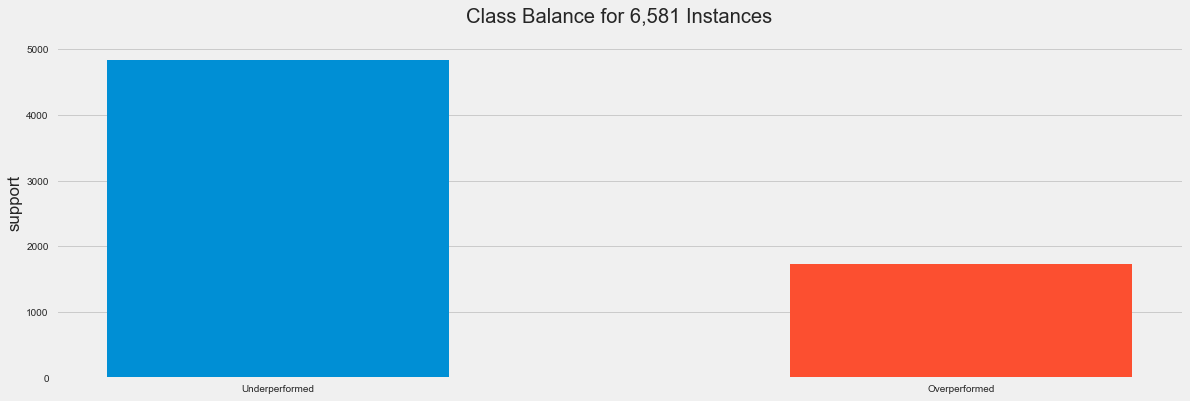

In [34]:
visualizer = ClassBalance(labels=['Underperformed','Overperformed'])

visualizer.fit(y) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

### Model Selection
<a id='model_selection_cell'></a>

#### Selecting Columns 
<a id='column_selection_cell'></a>
From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html):
> Create a callable to select columns to be used with ColumnTransformer.   
>   
>```make_column_selector``` can select columns based on datatype or the columns name with a regex. When using multiple selection criteria, all criteria must match for a column to be selected.

In [35]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

#### Selecting models to score
<a id='model_scoring_selection_cell'></a>

In [36]:
# list of models to use
models = [
    SVC(),
    NuSVC(),
    LinearSVC(),
    SGDClassifier(),
    KNeighborsClassifier(),
    LogisticRegression(),
    LogisticRegressionCV(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    RandomForestClassifier()
]

Here's a function to send each model through a pipeline and which generates an F1 score at the end

In [37]:
# function to score models
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    
    # handle_unknown='ignore' in OneHotEncoder() is used because weather_detail data gave it trouble
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', MinMaxScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('estimator', estimator)
    ])

    #add train/test split (train 14 weeks and below, test above 14 weeks)
    y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
    y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
    X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
    X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')
    
    # Instantiate the classification model and visualizer
    model.fit(X_train, y_train, **kwargs) #updated to train with train set
    expected  = y_test #updated with test set
    predicted = model.predict(X_test)  #updated with test set
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

Here's a function to send each model through the same pipeline and generate a visualization of precision, recall, and F1 scores for each class at the end

In [38]:
# function to visualize models
def visualize_model(X, y, estimator, **kwargs):
    """
    Visualizes models
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scalar', MinMaxScaler(), numeric),
        ('scalar2', MinMaxScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
    ])
    
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Underperformed', 'Overperformed'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    
    
    #add train/test split (train 14 weeks and below, test above 14 weeks)
    y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
    y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
    X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
    X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')
    
    visualizer.fit(X_train, y_train) #updated with train set
    visualizer.score(X_test, y_test) #updated with test set
    visualizer.show()

#### Scoring and visualizing selected models
<a id='scoring_models_cell'></a>

Iterate through list of initial models using X and y as defined above

F1 SCORE SVC: 0.5449101796407185


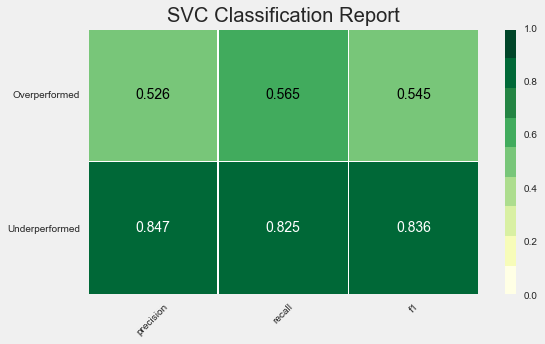

F1 SCORE NuSVC: 0.5432835820895521


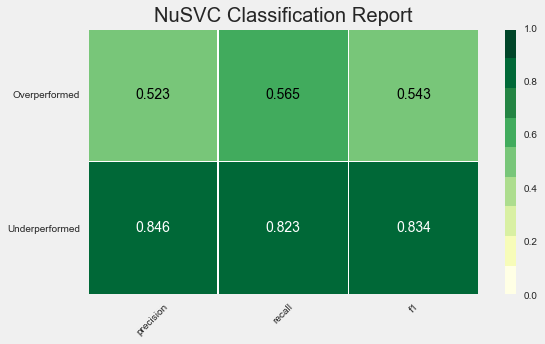

F1 SCORE LinearSVC: 0.5206349206349206


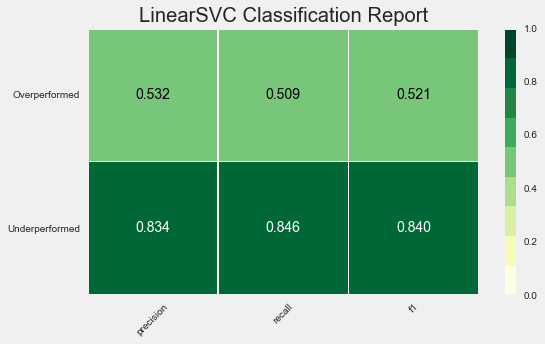

F1 SCORE SGDClassifier: 0.5413533834586465


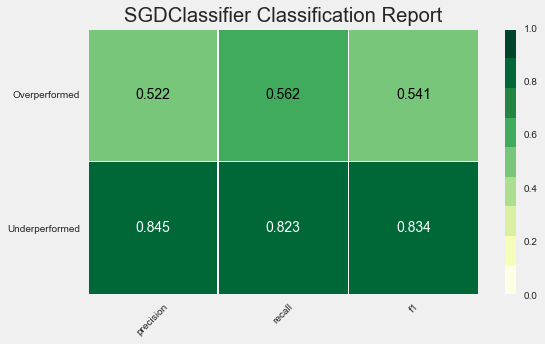

F1 SCORE KNeighborsClassifier: 0.39611650485436894


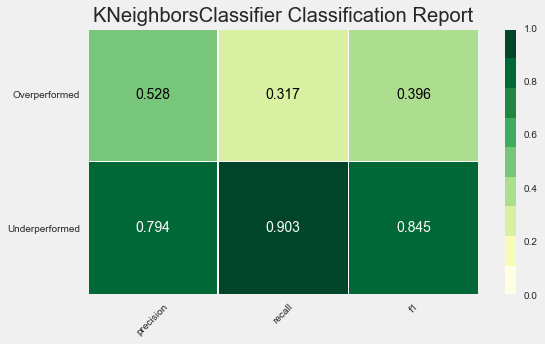

/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

F1 SCORE LogisticRegression: 0.5128205128205129


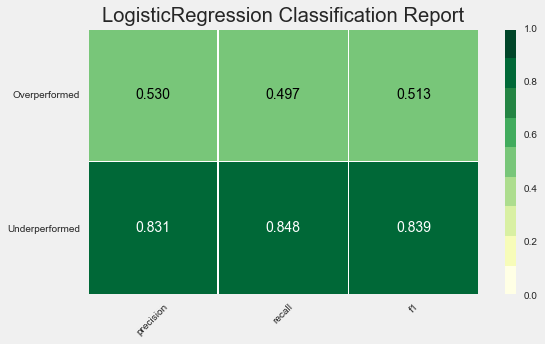

/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

F1 SCORE LogisticRegressionCV: 0.5297805642633229


/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

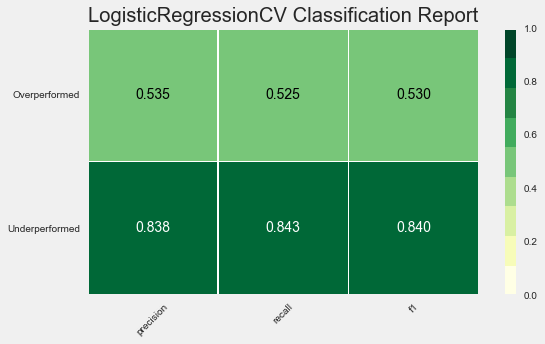

F1 SCORE BaggingClassifier: 0.4542483660130719


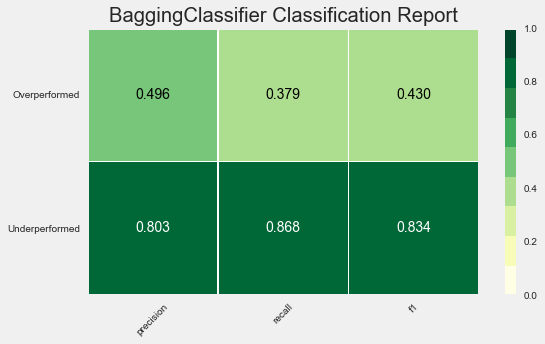

F1 SCORE ExtraTreesClassifier: 0.49354838709677423


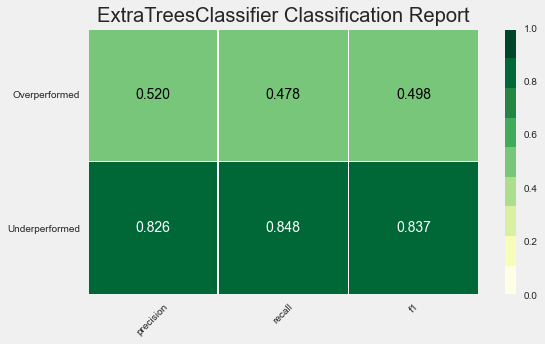

F1 SCORE RandomForestClassifier: 0.5056360708534621


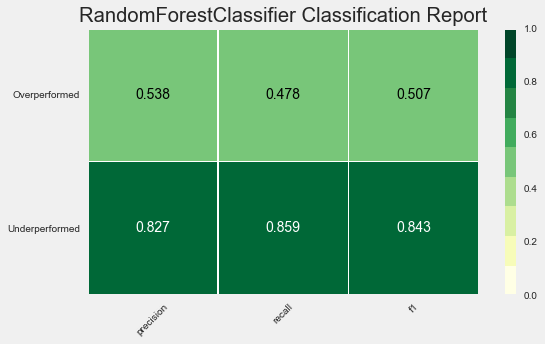

In [39]:
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

Adding some basic parameter tuning for this slate of models before cutting any from the model selection process

In [40]:
# list of models to use
modified_models = [
    SVC(gamma = 'auto'),
    NuSVC(gamma = 'auto'),
    LinearSVC(max_iter = 1000),
    SGDClassifier(max_iter = 100),
    KNeighborsClassifier(n_neighbors = 10),
    LogisticRegression(solver = 'lbfgs'),
    LogisticRegressionCV(cv=3, max_iter=100),
    BaggingClassifier(n_estimators = 15),
    ExtraTreesClassifier(n_estimators = 300),
    RandomForestClassifier(n_estimators = 300)
]

Trying the list of modified models with some basic paramater tuning

F1 SCORE SVC: 0.5432835820895521


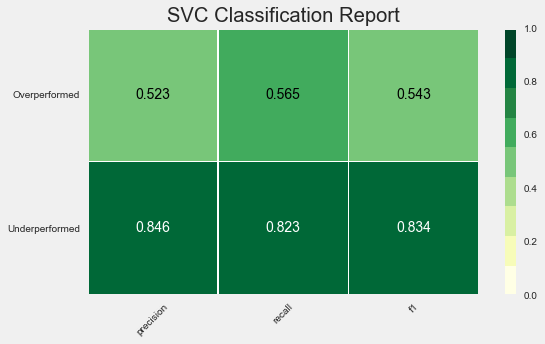

F1 SCORE NuSVC: 0.5432835820895521


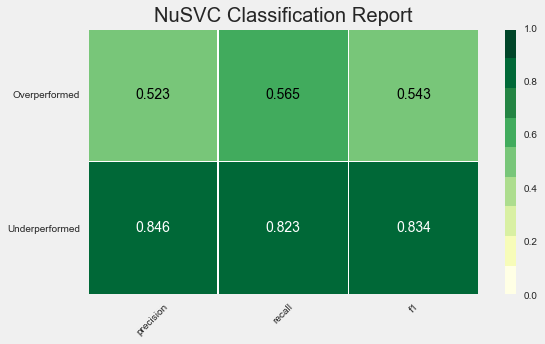

F1 SCORE LinearSVC: 0.5206349206349206


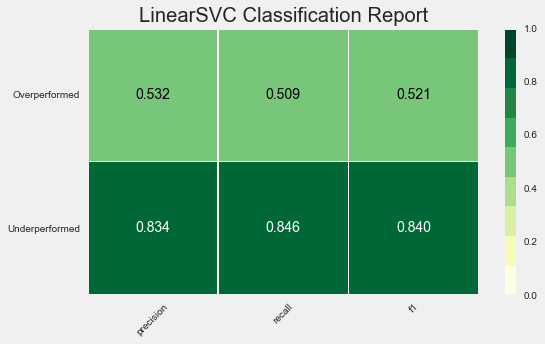

F1 SCORE SGDClassifier: 0.5419161676646707


/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


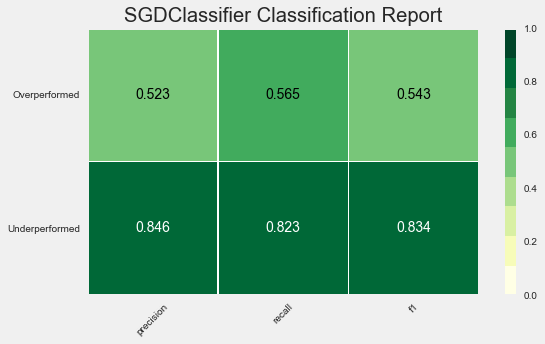

F1 SCORE KNeighborsClassifier: 0.2642369020501139


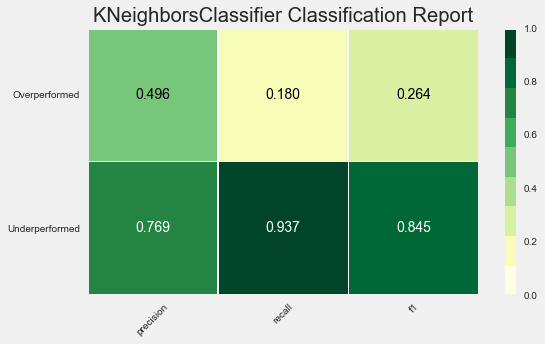

/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

F1 SCORE LogisticRegression: 0.5128205128205129


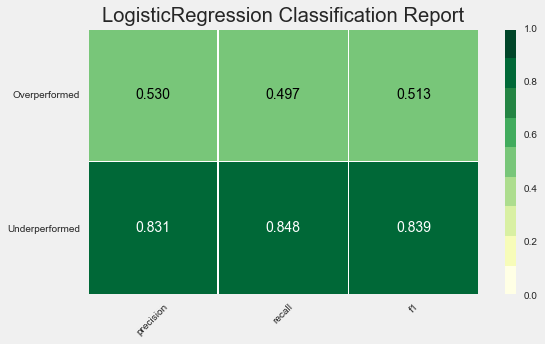

/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

F1 SCORE LogisticRegressionCV: 0.5213270142180094


/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

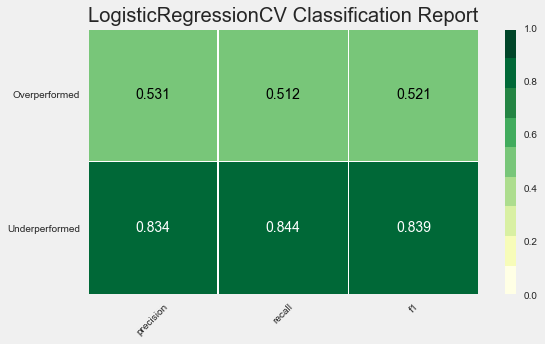

F1 SCORE BaggingClassifier: 0.5070866141732284


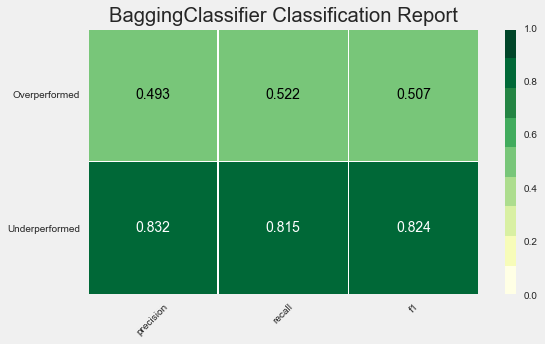

F1 SCORE ExtraTreesClassifier: 0.4967948717948718


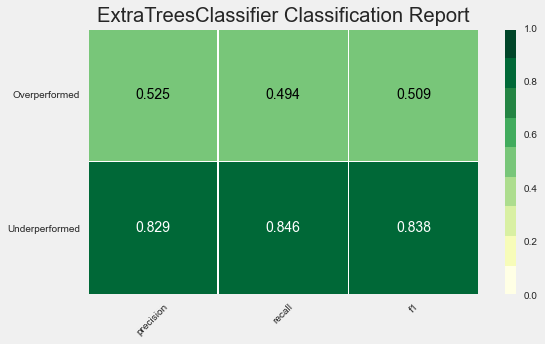

F1 SCORE RandomForestClassifier: 0.5221518987341772


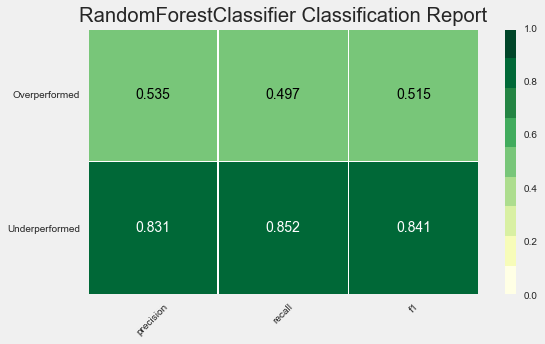

In [41]:
for model in modified_models:
    score_model(X, y, model)
    visualize_model(X, y, model)

Some of the models need some slight tuning to improve.

In [42]:
#changing gamma from auto to scale in SVC and NuSVC to see will models improve

good_models = [
    ## SVC: 0.565
    SVC(
        gamma = 'scale',
        class_weight = 'balanced'
    ),
   ##NuSVCC: 0.565
    NuSVC(
        gamma = 'scale',
        class_weight = 'balanced'
    ),
    # SGDClassifier: 0.562
    SGDClassifier(
        max_iter = 100,
        class_weight = 'balanced'
    ),
]

F1 SCORE SVC: 0.5333333333333333


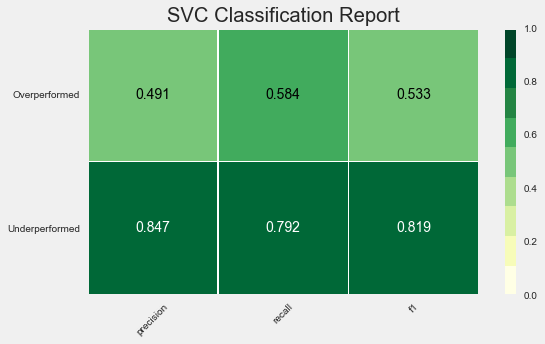

F1 SCORE NuSVC: 0.5432835820895521


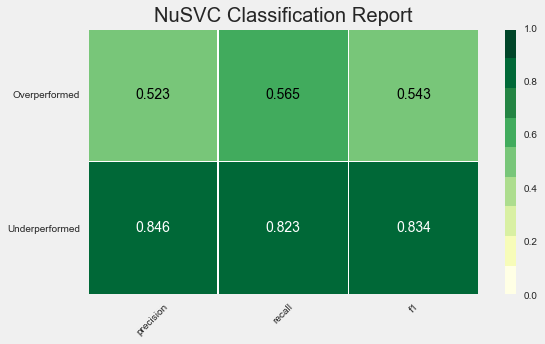

F1 SCORE SGDClassifier: 0.5197889182058046


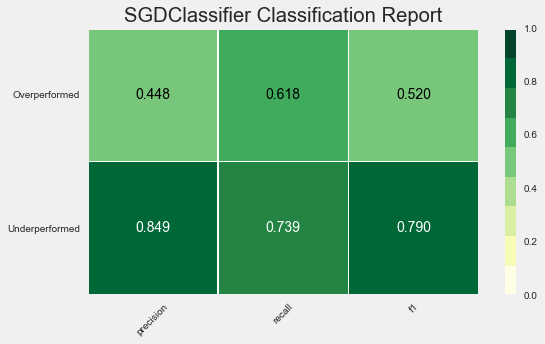

In [43]:
for model in good_models:
    score_model(X, y, model)
    visualize_model(X, y, model)

[return to top](#header_cell)
### Grid Search
<a id='grid_search_cell'></a>

#### Grid Searching the Support Vector Classifier
<a id='svc_gridsearch_cell'></a>

I'll start by setting different parameters for grid search to go through for, including:
* C: 4 variations of the regularization parameter
* kernel: linear model and radial basis function
* gamma: 5 kernel coefficient variations
* class_weight balanced for our imbalanced class

In [44]:
param_grid_SVC = {
    'C' : [1, 10],
    'gamma' : ['scale','auto'],
    'kernel' : ['linear', 'rbf','poly'],
    'class_weight' : ['balanced']
}

Make a pre-processing pipeline to send the SVC model through prior to GridSearchCV

In [45]:
preprocessor = Pipeline(
    [
        ("columns", ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
                ('scalar', MinMaxScaler(), numeric),
                ('scalar2', MinMaxScaler(), numeric2),
            ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Apply the preprocessor to X_train and X_test

In [46]:
y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')

In [47]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

Apply a LabelEncoder to y_train and y_test

In [48]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

Set up and run GridSearchCV

In [49]:
grid = GridSearchCV(
    # model: SVC
    SVC(),
    # Using the parameters defined above
    param_grid_SVC,
    # Refit an estimator using the best found parameters on the whole dataset
    refit = True,
    # >1 : the computation time for each fold and parameter candidate is displayed;
    # >2 : the score is also displayed;
    verbose = 2,
    # Maximize CPU
    n_jobs = -1
)

In [50]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10], 'class_weight': ['balanced'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

Find the best parameters for the SVC model

In [51]:
grid.best_params_

{'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}

See how these parameters make the model perform

F1 SCORE SVC: 0.5432835820895521


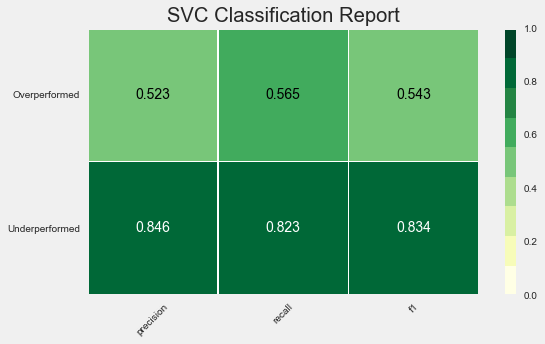

In [52]:
score_model(X, y, SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'auto',
    kernel = 'rbf'
))    

visualize_model(X, y, SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'auto',
    kernel = 'rbf'
))

Recall score for overperformance went down so I will try to tune parameters more:

-if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
if ‘auto’, uses 1 / n_features.

-Since ‘rbf’ and ‘poly’ use a non linear hyper-plane, this time I will change kernel to poly


F1 SCORE SVC: 0.5364583333333334


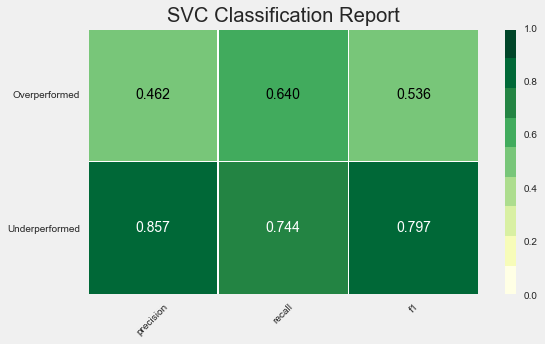

In [53]:
score_model(X, y, SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'scale',
    kernel = 'poly'
))    

visualize_model(X, y, SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'scale',
    kernel = 'poly'
))

[return to top](#header_cell)
### SDG Classifier GridSearchCV

#### Grid Searching the Stochastic Gradient Descent Classifier
<a id='sdg_gridsearch_cell'></a>

I'll start by setting different parameters for grid search to go through for, including:
* loss: measures model (mis) fit. 'hinge' is similar to SVC, and 'log' is similar to logsitic regressiono
* max_iter: 100 and 500 passes over the training data
* penalty: L1 (leads to sparse solutions) and L2
* n_jobs: -1 maximizes CPUs used to speed up the model
* class_weight: balanced for our imbalanced class

In [54]:
param_grid_SDGClassifier = {
    'loss': ['hinge','log'],
    'max_iter' : [100, 500],
    'penalty': ['l1','l2'],
    'n_jobs': [-1],
    'class_weight' : ['balanced']
}

In [55]:
grid = GridSearchCV(
    # model: SVC
    SGDClassifier(),
    # Using the parameters defined above
    param_grid_SDGClassifier,
    # Refit an estimator using the best found parameters on the whole dataset
    refit = True,
    # >1 : the computation time for each fold and parameter candidate is displayed;
    # >2 : the score is also displayed;
    verbose = 2
)

In [56]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l1; total time=   0.0s


/Users/erminamujan/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=100, n_jobs=-1, penalty=l2; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.0s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.1s
[CV] END class_weight=balanced, loss=hinge, max_iter=500, n_jobs=-1, penalty=l1; total time=   0.0s


GridSearchCV(estimator=SGDClassifier(),
             param_grid={'class_weight': ['balanced'], 'loss': ['hinge', 'log'],
                         'max_iter': [100, 500], 'n_jobs': [-1],
                         'penalty': ['l1', 'l2']},
             verbose=2)

In [57]:
grid.best_params_

{'class_weight': 'balanced',
 'loss': 'log',
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'l2'}

See how these parameters make the model perform

F1 SCORE SGDClassifier: 0.5244338498212158


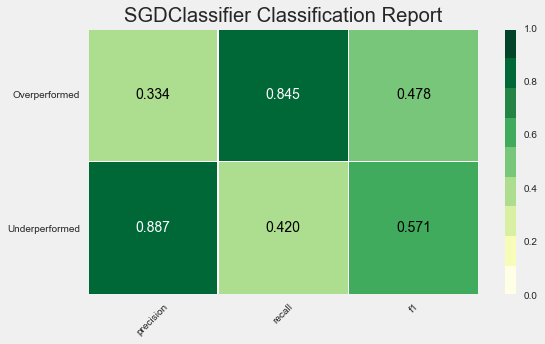

In [66]:
score_model(X, y, SGDClassifier(
    class_weight = 'balanced',
    loss = 'log',
    max_iter = 100,
    n_jobs = -1,
    penalty = 'l2'
)) 

visualize_model(X, y, SGDClassifier(
    class_weight = 'balanced',
    loss = 'log',
    max_iter = 100,
    n_jobs = -1,
    penalty = 'l2'
))

[return to top](#header_cell)
#### Visualizing Model Performance with a Confusion Matrix
<a id='confusion_matrix_cell'></a>

In [59]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop(['performance'], axis = 'columns')

y = df['performance']

In [60]:
y_train = y[:X.index[X['Week'] > 14].tolist()[0]]
y_test = y[X.index[X['Week'] > 14].tolist()[0]:]
X_train = X[:X.index[X['Week'] > 14].tolist()[0]].drop('Week', axis = 'columns')
X_test = X[X.index[X['Week'] > 14].tolist()[0]:].drop('Week', axis = 'columns')

preprocessor = Pipeline(
    [
        ("columns", ColumnTransformer(
            [
                ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical),
                ('scalar', MinMaxScaler(), numeric),
                ('scalar2', MinMaxScaler(), numeric2),
            ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

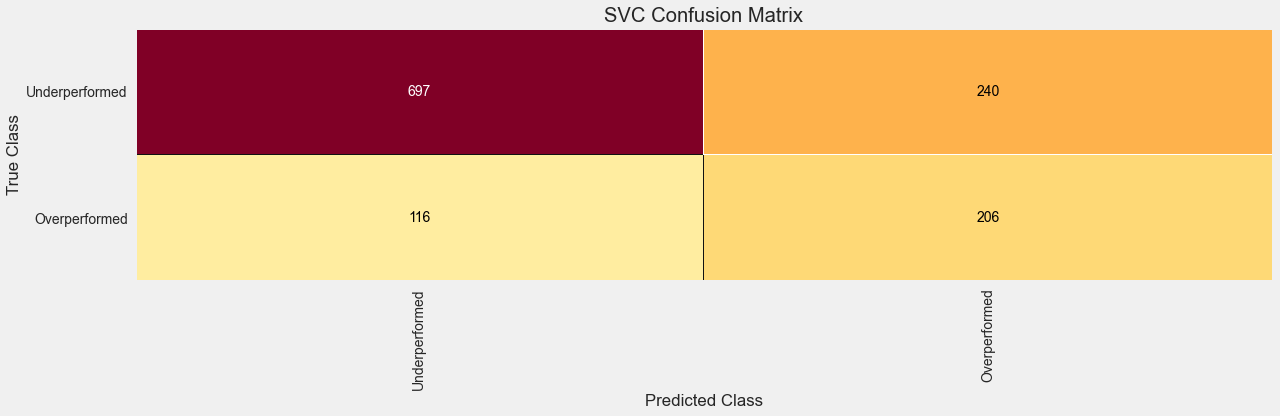

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [61]:
from yellowbrick.classifier import ConfusionMatrix

model = SVC(
    C = 1,
    class_weight = 'balanced',
    gamma = 'scale',
    kernel = 'poly'
)

cm = ConfusionMatrix(
    model,
    classes = ['Underperformed', 'Overperformed']
)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

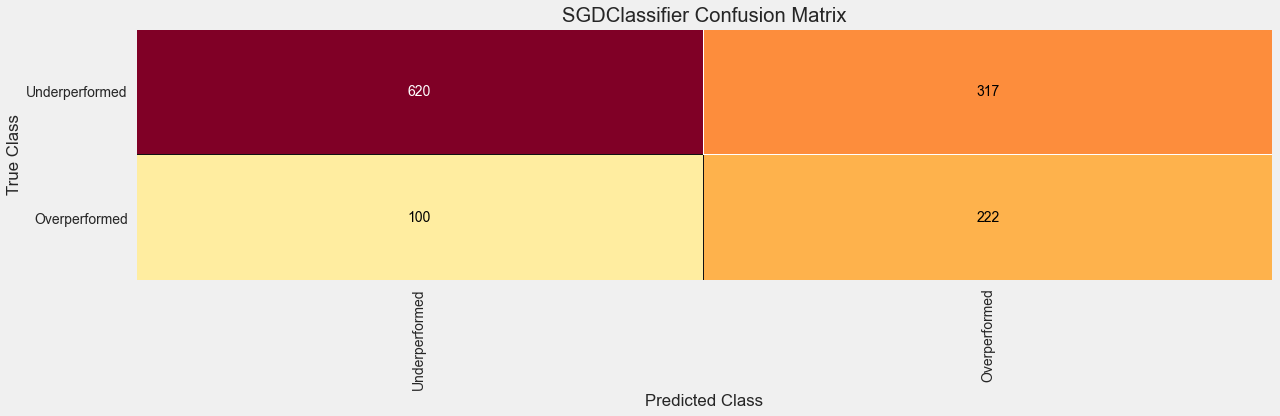

<AxesSubplot:title={'center':'SGDClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [67]:
from yellowbrick.classifier import ConfusionMatrix

model = SGDClassifier(
    class_weight = 'balanced',
    loss = 'log',
    max_iter = 100,
    n_jobs = -1,
    penalty = 'l2'
)

cm = ConfusionMatrix(
    model,
    classes = ['Underperformed', 'Overperformed']
)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

[return to top](#header_cell)
### Time Series Split Cross Validation
<a id='time_series_split_cv'></a>
Performing a time series split cross validation to check the mean and standard deviation for each week's data

In [63]:
X_cv = preprocessor.fit_transform(X)
y_cv = LabelEncoder().fit_transform(y)
X_cv = pd.DataFrame(X_cv)
y_cv = pd.DataFrame(y_cv)

from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
for n in range(1,18):
    print(f'Cross-validating fold {n}')
    # prepare the cross-validation procedure
    cv = KFold(
        n_splits = n+1,
        random_state = 123,
        shuffle = True
    )
    # create model
    model = SGDClassifier(
        class_weight = 'balanced',
        loss = 'hinge',
        max_iter = 500,
        n_jobs = -1,
        penalty = 'l1'
    )
    # evaluate model
    scores = cross_val_score(
        model,
        X_cv[:(X[X['Week'] <= n].index.to_list()[-1] + 1)],
        y_cv[:(X[X['Week'] <= n].index.to_list()[-1] + 1)],
        scoring = 'accuracy',
        cv = cv,
        n_jobs = -1
    )
    # report performance
    means = []
    means.append(mean(scores))
    print(
        f'Accuracy: Mean: {mean(scores)}, stdev: {std(scores)}'
        '\n'
    )
print(f'Mean of mean scores: {sum(means) / len(means)}')

Cross-validating fold 1
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 2
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 3
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 4
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 5
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 6
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 7
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 8
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 9
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 10
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 11
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 12
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 13
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 14
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 15
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 16
Accuracy: Mean: nan, stdev: nan

Cross-validating fold 17
Accuracy: Mean: nan, stdev: nan

Mean of mean scores: na

[return to top](#header_cell)
### Pickling the Model for Future Use
<a id='pickling_cell'></a>

In [68]:
import pickle

In [69]:
filename = '../../foo/wide_receiver_model.sav'
pickle.dump(model, open(filename, 'wb'))